In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split as split


In [74]:
#read file
df = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

In [76]:
#check for duplicates
num_duplicates = df.duplicated().sum()
print("Number of Duplicate Rows:", num_duplicates)

Number of Duplicate Rows: 0


In [77]:
#print the inconsistent column name and their data types
for col in df.columns:
    if 'Density' in col:
        print(f"Column Name: {col}, Data Type: {df[col].dtype}")

# Fixing inconsistency in column names and converting 'Density' columns to float
df = df.rename(columns={col: 'Density' for col in df.columns if 'Density' in col})
df['Density'] = df['Density'].astype(str).str.replace(',', '').astype(float)



Column Name: Density\n(P/Km2), Data Type: object


In [78]:
#check for missing values
df.isna().sum()

Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                               10
Access to clean fuels for cooking                                    169
Renewable-electricity-generating-capacity-per-capita                 931
Financial flows to developing countries (US $)                      2089
Renewable energy share in the total final energy consumption (%)     194
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          207
Value_co2_emissions_kt_by_country                  

In [79]:
# remove rows with too many missing values
df = df.drop(columns = ['Financial flows to developing countries (US $)'])
df = df.drop(columns = ['Renewables (% equivalent primary energy)'])
df = df.drop(columns = ['Renewable-electricity-generating-capacity-per-capita'])

# drop rows where critical columns are missing
df = df.dropna(subset=['Latitude', 'Longitude', 'Land Area(Km2)', 'Density'])

# impute missing values based on Entity
columns_to_fill = [
    'Access to clean fuels for cooking', 
    'Renewable energy share in the total final energy consumption (%)', 
    'Electricity from nuclear (TWh)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
    'Value_co2_emissions_kt_by_country', 'gdp_growth','gdp_per_capita',
    'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 
    'Low-carbon electricity (% electricity)', 'Access to electricity (% of population)'
]

for col in columns_to_fill:
    # impute mean by Entity
    df[col] = df.groupby('Entity')[col].transform(lambda x: x.fillna(x.mean()))
    
    # impute global mean as fallback
    global_mean = df[col].mean()
    df[col] = df[col].fillna(global_mean)

In [80]:
# encode categorical variables (entity)
label_encoder = LabelEncoder()
df['Entity_encoded'] = label_encoder.fit_transform(df['Entity'])

In [81]:
#sort values by Year and Entity
df = df.sort_values(by=['Year', 'Entity']).reset_index(drop=True)

# Define features and target variable
X = df.drop(columns = ['Primary energy consumption per capita (kWh/person)','Entity'])
y = df['Primary energy consumption per capita (kWh/person)']


--- Model-based Selection ---
1. Access to clean fuels for cooking
2. Renewable energy share in the total final energy consumption (%)
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP)
4. gdp_per_capita
5. Density
6. Land Area(Km2)
7. Latitude
8. Longitude
9. Entity_encoded


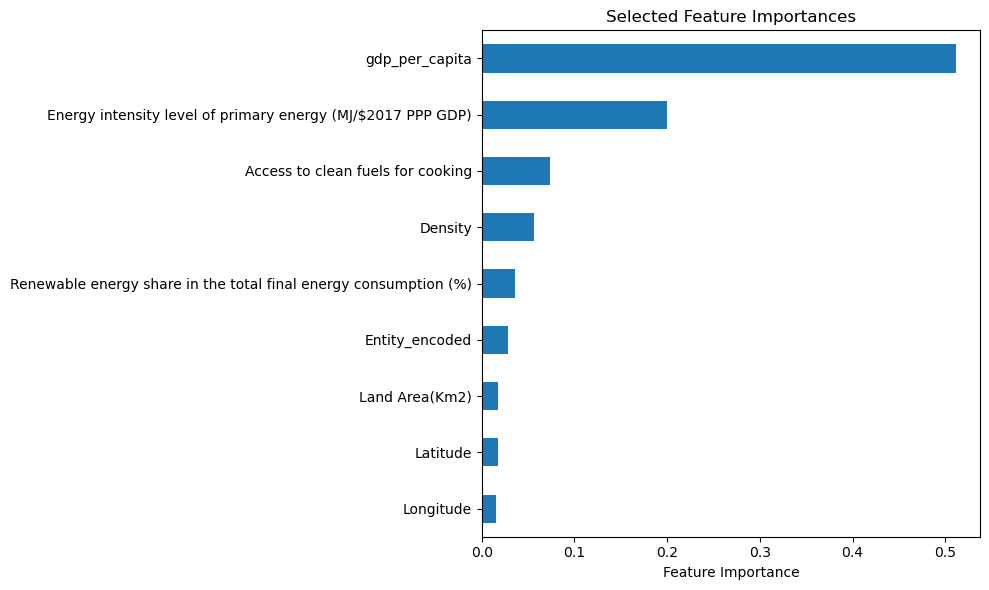

In [82]:
#feature selection using model-based approach
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
features = selector.fit_transform(X, y)
selected = selector.get_support()

selected_features = X.columns[selected].tolist()

#print selected features with numbering
print("\n--- Model-based Selection ---")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
    

X_selected = X[selected_features]

#visualize selected features using bar plot
feature_importances = selector.estimator_.feature_importances_[selected]
feature_importances = pd.Series(feature_importances, index=selected_features).sort_values()
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Selected Feature Importances')
plt.tight_layout()
plt.show()



In [83]:
train = df.loc[df.Year < 2017]
test = df.loc[df.Year >= 2017]

Target = 'Primary energy consumption per capita (kWh/person)'

X_train = train[X_selected.columns]
y_train = train[Target]

X_test = test[X_selected.columns]
y_test = test[Target]

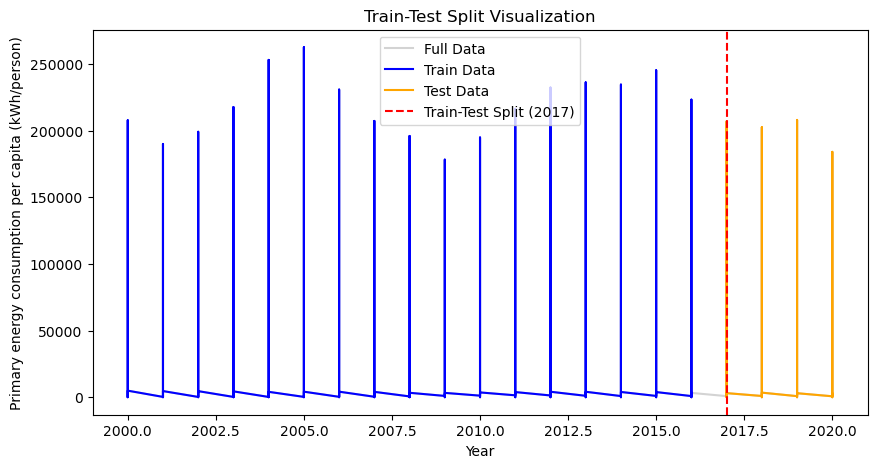

In [84]:
#add visualization for train and test split u
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df[Target], label='Full Data', color='lightgray')
plt.plot(train['Year'], y_train, label='Train Data', color='blue')
plt.plot(test['Year'], y_test, label='Test Data', color='orange')
plt.axvline(x=2017, color='red', linestyle='--', label='Train-Test Split (2017)')
plt.xlabel('Year')
plt.ylabel(Target)
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()

*Part 2: Model Training*  

In [85]:
final_model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Final Model R²: {r2:.4f}')
print(f'Final Model MAE: {mae:.4f}')

Final Model R²: 0.9656
Final Model MAE: 3119.3297


In [86]:
print(df.columns)

Index(['Entity', 'Year', 'Access to electricity (% of population)',
       'Access to clean fuels for cooking',
       'Renewable energy share in the total final energy consumption (%)',
       'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)',
       'Electricity from renewables (TWh)',
       'Low-carbon electricity (% electricity)',
       'Primary energy consumption per capita (kWh/person)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Value_co2_emissions_kt_by_country', 'gdp_growth', 'gdp_per_capita',
       'Density', 'Land Area(Km2)', 'Latitude', 'Longitude', 'Entity_encoded'],
      dtype='object')


In [87]:
#X=df.drop(columns= ['Primary energy consumption per capita (kWh/person)', 'Entity', 'Year'])
#y= df['Primary energy consumption per capita (kWh/person)']

X_train, X_test, y_train, y_test= split(X_selected, y, train_size= 0.2, random_state=42)

In [88]:
#model definition
results= []
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge(alpha=10)
models['svr'] =SVR()

In [89]:
kf= KFold(n_splits=5, shuffle= True, random_state=42)

In [90]:
#ts= TimeSeriesSplit(n_splits=3)

In [104]:
result_cp= []

for n in models:
#    scores= cross_val_score(models[n], X_selected, y, cv=kf, n_jobs=-1)
    scores= cross_val_score(models[n], X_selected, y, cv=kf, n_jobs=-1)
    print(f'model: {n} {scores.mean():.3%} +/- {scores.std():.3%}')

    result_cp.append({
        'Model': n,
        'R2 Mean': scores.mean()
    })

model: lnr 63.730% +/- 0.945%
model: knn 89.797% +/- 1.818%
model: rfr 98.233% +/- 0.433%
model: mpr 58.554% +/- 3.877%
model: gbr 96.433% +/- 0.431%
model: dtr 95.945% +/- 1.534%
model: rrn 63.730% +/- 0.945%
model: svr -13.129% +/- 0.953%


In [92]:
cp_df= pd.DataFrame(result_cp)
cp_df

,Model,R2 Mean
0,lnr,0.637300
1,knn,0.897966
2,rfr,0.982542
3,mpr,0.544769
4,gbr,0.964173
5,dtr,0.958809
6,rrn,0.637300
7,svr,-0.131290


In [93]:
scalers ={}
scalers['mms']= MinMaxScaler()
scalers['std']= StandardScaler()
scalers['rbs']= RobustScaler()


In [105]:
#finding the best scaler
results= []

#tss= TimeSeriesSplit(n_splits=3)
#scaler for loop
for s in scalers:
    X_train_scaled= scalers[s].fit_transform(X_train)
    X_test_scaled= scalers[s].transform(X_test)
    print(f'---- With {s} Scaling: ----\n')
    #model for loop
    for n in models:
        scores= cross_val_score(models[n], X_train_scaled, y_train ,cv= kf, n_jobs=-1)
        print(f'Models: {n}: {scores.mean():.3%} +/- {scores.std():.3%}')
        results.append({
            'Scaler': s, 
            'Model': n, 
            'R2 Mean':scores.mean()
            })

---- With mms Scaling: ----

Models: lnr: 62.564% +/- 4.463%
Models: knn: 84.167% +/- 4.053%
Models: rfr: 90.003% +/- 5.325%
Models: mpr: -56.678% +/- 11.439%
Models: gbr: 91.925% +/- 2.960%
Models: dtr: 87.384% +/- 5.749%
Models: rrn: 55.093% +/- 2.422%
Models: svr: -13.690% +/- 4.474%
---- With std Scaling: ----

Models: lnr: 62.564% +/- 4.463%
Models: knn: 88.584% +/- 2.731%
Models: rfr: 90.229% +/- 4.529%
Models: mpr: -56.395% +/- 11.440%
Models: gbr: 91.965% +/- 2.963%
Models: dtr: 87.560% +/- 7.864%
Models: rrn: 62.672% +/- 4.478%
Models: svr: -13.696% +/- 4.460%
---- With rbs Scaling: ----

Models: lnr: 62.564% +/- 4.463%
Models: knn: 85.930% +/- 2.595%
Models: rfr: 90.217% +/- 5.121%
Models: mpr: -55.094% +/- 11.324%
Models: gbr: 92.051% +/- 2.747%
Models: dtr: 87.369% +/- 7.916%
Models: rrn: 62.512% +/- 4.573%
Models: svr: -13.711% +/- 4.484%


In [95]:
result_df= pd.DataFrame(results)

print(result_df)

   Scaler Model   R2 Mean
0     mms   lnr  0.625642
1     mms   knn  0.841666
2     mms   rfr  0.904796
3     mms   mpr -0.566449
4     mms   gbr  0.920623
5     mms   dtr  0.874354
6     mms   rrn  0.550934
7     mms   svr -0.136904
8     std   lnr  0.625642
9     std   knn  0.885841
10    std   rfr  0.905430
11    std   mpr -0.564075
12    std   gbr  0.921385
13    std   dtr  0.875365
14    std   rrn  0.626723
15    std   svr -0.136961
16    rbs   lnr  0.625642
17    rbs   knn  0.859297
18    rbs   rfr  0.903019
19    rbs   mpr -0.550762
20    rbs   gbr  0.920886
21    rbs   dtr  0.866853
22    rbs   rrn  0.625123
23    rbs   svr -0.137108


In [96]:
#robustscaler chosen as the scaler
scl= RobustScaler()
Xs_train= scl.fit_transform(X_train)
Xs_test= scl.transform(X_test)

In [97]:
#get the R2 mean value
result_rb= []
for r in models:
        scores= cross_val_score(models[r], X_train_scaled, y_train ,cv= tss, n_jobs=-1)
        print(f'Models: {r}: {scores.mean():.3%} +/- {scores.std():.3%}')
        result_rb.append({
            'Model': r, 
            'R2 Mean':scores.mean()
            })

Models: lnr: 64.960% +/- 3.075%
Models: knn: 76.534% +/- 10.347%
Models: rfr: 86.929% +/- 4.403%
Models: mpr: -57.377% +/- 10.846%
Models: gbr: 88.944% +/- 5.063%
Models: dtr: 70.661% +/- 8.106%
Models: rrn: 64.627% +/- 3.094%
Models: svr: -14.445% +/- 6.167%


In [98]:
#save the result so that can be used to plot
rb_df= pd.DataFrame(result_rb)

print(rb_df)

  Model   R2 Mean
0   lnr  0.649597
1   knn  0.765336
2   rfr  0.869293
3   mpr -0.573768
4   gbr  0.889439
5   dtr  0.706614
6   rrn  0.646267
7   svr -0.144447


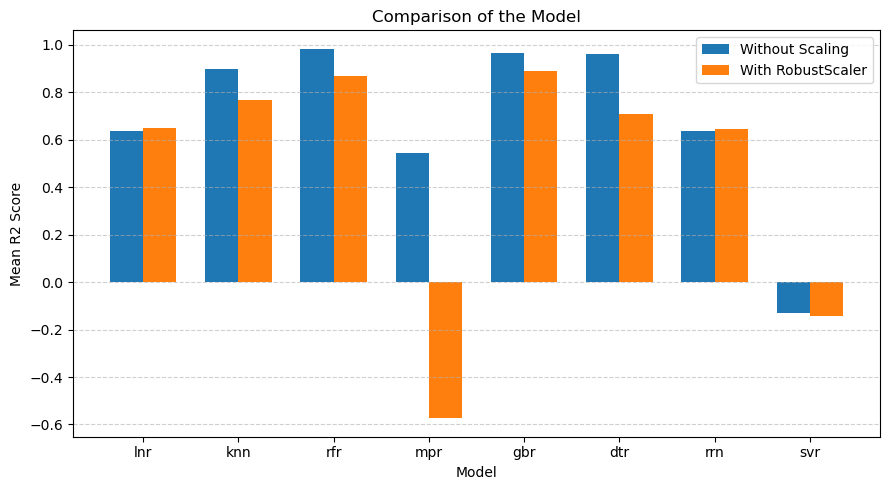

In [99]:
#plot the graph for comparison
models= cp_df['Model']
x= np.arange(len(models))
width= 0.35

plt.figure(figsize=(9, 5))

plt.bar(x- width/2, cp_df['R2 Mean'], width, label= 'Without Scaling')
plt.bar(x+ width/2, rb_df['R2 Mean'], width, label= 'With RobustScaler')

plt.xticks(x, models)
plt.title('Comparison of the Model')
plt.ylabel('Mean R2 Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [100]:
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge(alpha=10)
models['svr'] =SVR()

In [101]:
#plot the graph
plt.figure(figsize=(18,12))

for i,h in enumerate(models, start=1):
    #models[h].fit(X_train_scaled, y_train)
    y_pred= models[h].predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)

    plt.subplot(3,3,i)
    plt.scatter(y_test,y_pred, alpha=0.6, edgecolors='k', s=20)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'{n}\nR2: {r2:.3f} | RMSE: {rmse:.1f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 1800x1200 with 0 Axes>

In [ ]:
rfr= RandomForestRegressor().fit(X_train, y_train)
print(f'Accuracy: {rfr.score(X_test, y_test):.3f}')

Accuracy: 0.966


In [ ]:
#doing hyperparameter tuning
tssh= TimeSeriesSplit(n_splits=3)

best_hyp= {}

hyp_grid = {
    'lnr': {'copy_X': [True, False], 'fit_intercept': [True, False]},
    'knn': {'leaf_size': [5, 10], 'n_neighbors': [20, 50], 'weights': ['uniform', 'distance']},
    'dtr': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
    'rfr': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'gbr': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
    'mpr': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['tanh', 'relu']},
    'svr': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}
for n in hyp_grid:
    grid_search= GridSearchCV(
        estimator= models[n],
        param_grid= hyp_grid[n],
        cv= tssh,
        scoring='r2',
        n_jobs= -1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_hyp[n]= grid_search.best_params_

    print(f'{n} Best CV Score: {grid_search.best_score_:.3%}')

models_tuned= {
    'lnr' :LinearRegression(**best_hyp['lnr']),
    'knn' :KNeighborsRegressor(**best_hyp['knn']),
    'rfr' :RandomForestRegressor(**best_hyp['rfr']),
    'mpr' :MLPRegressor(**best_hyp['mpr']),
    'gbr' :GradientBoostingRegressor(**best_hyp['gbr']),
    'dtr' :DecisionTreeRegressor(**best_hyp['dtr']),
    'rrn' :Ridge(alpha=10),
    'svr' :SVR(**best_hyp['svr'])
}


lnr Best CV Score: 63.342%
knn Best CV Score: 88.459%
dtr Best CV Score: 90.689%
rfr Best CV Score: 95.416%
gbr Best CV Score: 94.211%


c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


mpr Best CV Score: -39.266%
svr Best CV Score: 39.613%


In [ ]:
#calculate the R2 score, mae and rmse
final_result= []

for name, model in models_tuned.items():
    model.fit(X_train_scaled, y_train)
    y_pred= model.predict(X_test_scaled)

    r2= r2_score(y_test, y_pred)
    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    final_result.append({
        'Model': name,
        'R2 Score': r2,
        'MAE': mae,
        'RMSE': rmse
    })

final_df= pd.DataFrame(final_result)
final_df

c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,R2 Score,MAE,RMSE
0,lnr,0.635216,12776.515589,20311.840212
1,knn,0.960556,3389.871052,6679.199896
2,rfr,0.964373,3080.579539,6347.736021
3,mpr,-0.117248,20716.000723,35547.254589
4,gbr,0.952794,4418.640948,7306.839348
5,dtr,0.936959,3464.883741,8443.879918
6,rrn,0.635557,12691.598949,20302.336811
7,svr,0.529504,11062.727075,23067.959456


c:\Users\kangh\.conda\envs\dsf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


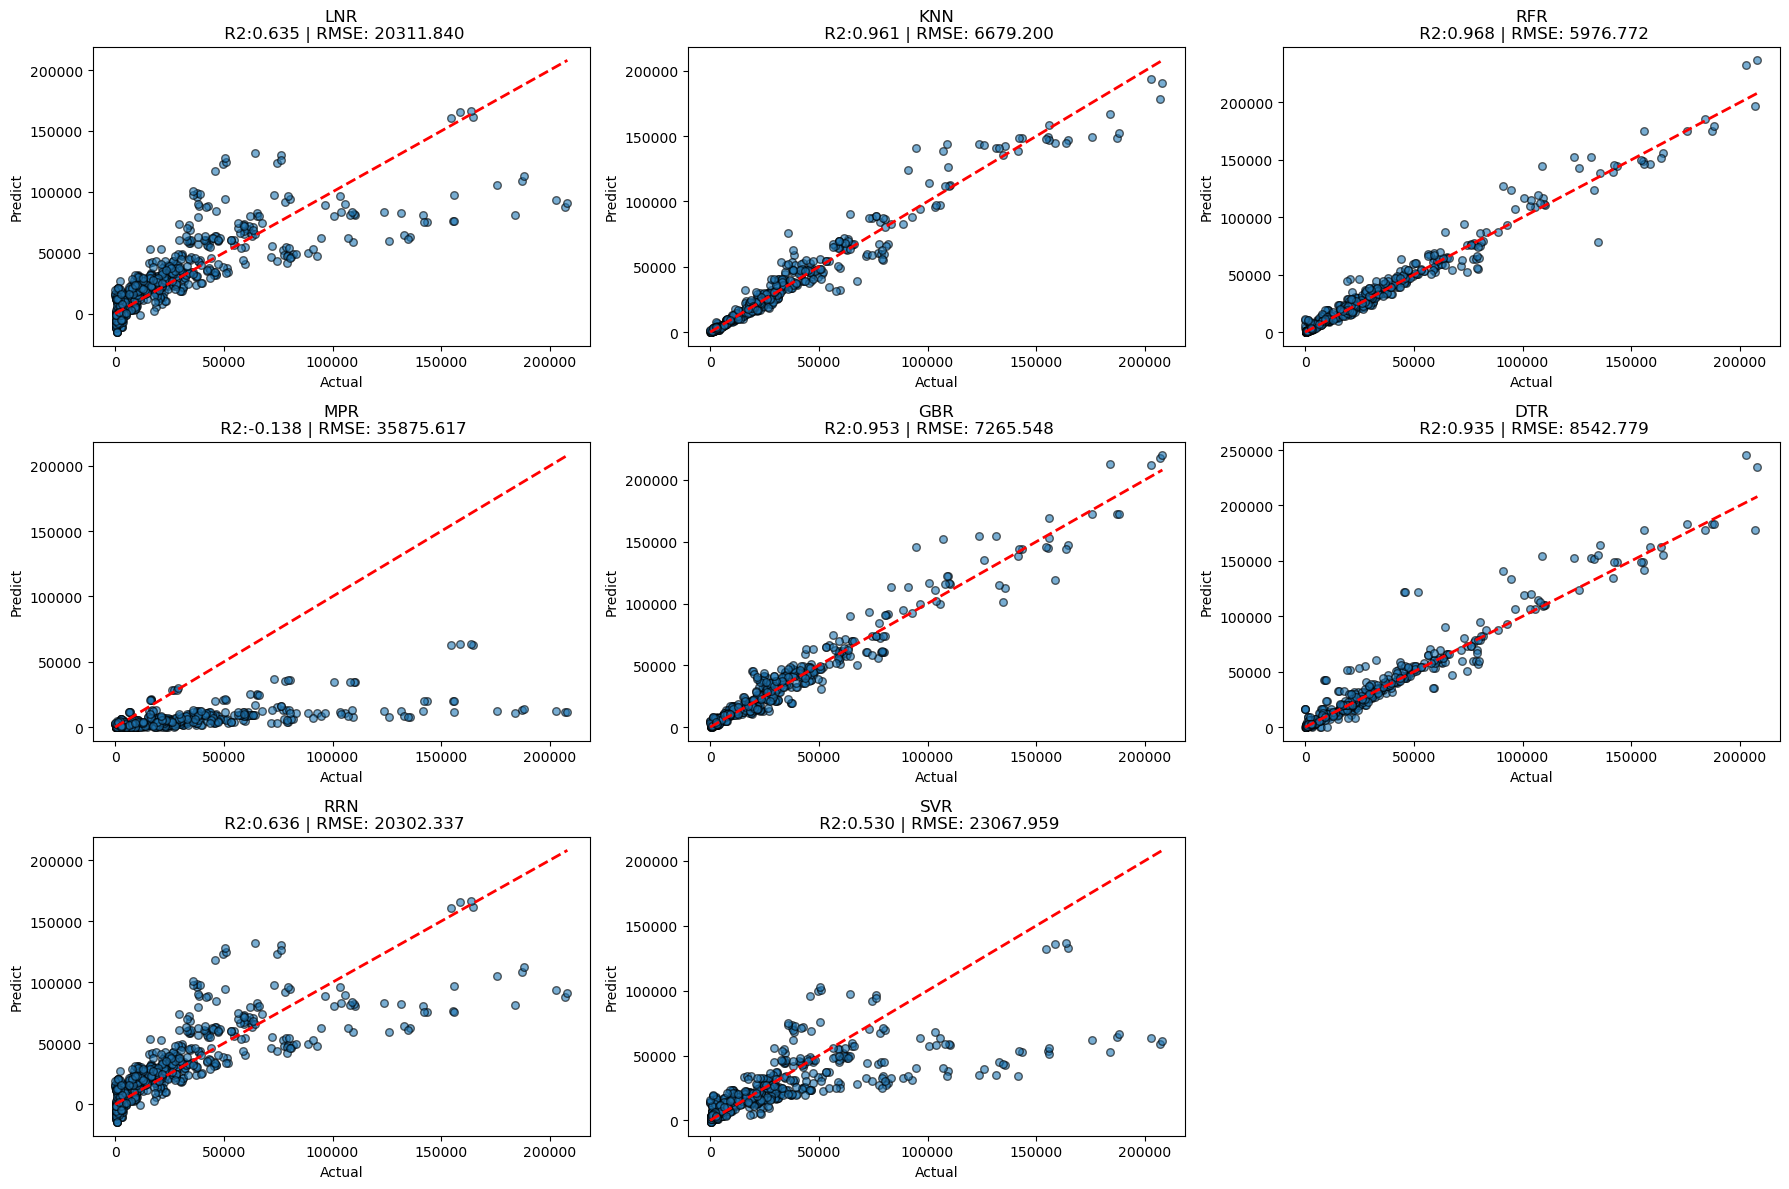

In [ ]:
#plot the graph
plt.figure(figsize= (18,12))

final_comparison= []

for i, n in enumerate(models_tuned, start=1):
    models_tuned[n].fit(X_train_scaled, y_train)
    y_pred= models_tuned[n].predict(X_test_scaled)

    rmse= np.sqrt(mean_squared_error(y_test, y_pred))
    mae= mean_absolute_error(y_test, y_pred)
    score= models_tuned[n].score(X_test_scaled, y_test)

    final_comparison.append({
        'Model': n,
        'R2 Mean': score,
        'RMSE': rmse,
        'MAE': mae
    })

    plt.subplot(3,3,i)
    plt.scatter(y_test, y_pred, alpha= 0.6, edgecolors= (0,0,0), s=30)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predict')
    plt.title(f'{n.upper()}\n R2:{score:.3f} | RMSE: {rmse:.3f}')

plt.tight_layout()
plt.show()

In [ ]:
#save the result
final_df= pd.DataFrame(final_comparison)
final_df

,Model,R2 Mean,RMSE,MAE
0,lnr,0.635216,20311.840212,12776.515589
1,knn,0.960556,6679.199896,3389.871052
2,rfr,0.968416,5976.771945,3029.831454
3,mpr,-0.137984,35875.616878,20925.749488
4,gbr,0.953326,7265.547547,4410.082073
5,dtr,0.935474,8542.778891,3568.081158
6,rrn,0.635557,20302.336811,12691.598949
7,svr,0.529504,23067.959456,11062.727075


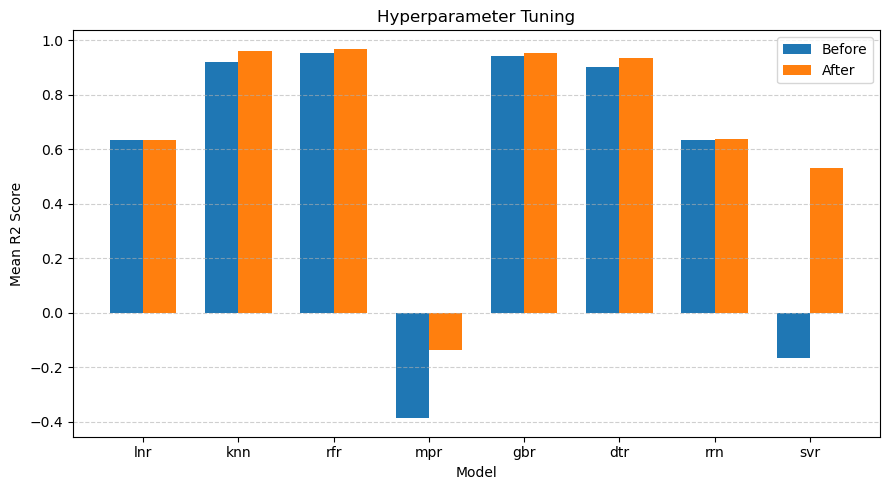

In [ ]:
#plot the graph for comparison
models= rb_df['Model']
x= np.arange(len(models))
width= 0.35

plt.figure(figsize=(9, 5))

plt.bar(x- width/2, rb_df['R2 Mean'], width, label= 'Before')
plt.bar(x+ width/2, final_df['R2 Mean'], width, label= 'After')

plt.xticks(x, models)
plt.title('Hyperparameter Tuning')
plt.ylabel('Mean R2 Score')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()